In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,TensorDataset

from google.colab import files
uploaded = files.upload()

books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')


Saving books.csv to books (2).csv
Saving ratings.csv to ratings (2).csv


In [27]:
books.isnull().sum()

,0
id,0
book_id,0
best_book_id,0
work_id,0
books_count,0
authors,0
original_publication_year,0
title,0
language_code,0
average_rating,0


In [26]:
books["language_code"].fillna(books["language_code"].mode()[0], inplace=True)
books["original_publication_year"].fillna(books["original_publication_year"].median(), inplace=True)
books.drop(columns=["isbn", "isbn13", "original_title"], inplace=True)

/tmp/ipython-input-1190540921.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books["original_publication_year"].fillna(books["original_publication_year"].median(), inplace=True)


In [28]:
ratings.head()
ratings.isnull().sum()

,0
book_id,0
user_id,0
rating,0


In [29]:
ratings['label'] = (ratings['rating'] >= 4).astype(int)

In [30]:
data = ratings.merge(books,left_on='book_id',right_on='book_id')
print(data.columns)

Index(['book_id', 'user_id', 'rating', 'label', 'id', 'best_book_id',
       'work_id', 'books_count', 'authors', 'original_publication_year',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')


In [35]:
features = ['average_rating','ratings_count','work_text_reviews_count','language_code']

X = data[features].copy()
y = data['label']

In [38]:
categorical_features = ['language_code']
numerical_features = ['average_rating', 'ratings_count', 'work_text_reviews_count']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
X_new = preprocessor.fit_transform(X)

In [39]:
X_train , X_test , y_train , y_test = train_test_split(X_new , y , test_size=0.2 , random_state=42,stratify = y)

In [54]:
class BookDataset(Dataset):
  def __init__(self,X,y):
    self.X = torch.tensor(X,dtype=torch.float32)
    self.y = torch.tensor(y.values,dtype=torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
train_dataset = BookDataset(X_train,y_train)
test_dataset = BookDataset(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32)

In [55]:
class MLP(nn.Module):
  def __init__(self,input_dim):
    super(MLP,self).__init__()
    self.w1 = nn.Linear(input_dim,128)
    self.relu1 = nn.ReLU()
    self.w2 = nn.Linear(128,64)
    self.relu2 = nn.ReLU()
    self.w3 = nn.Linear(64,1)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.relu1(self.w1(x))
    x = self.relu2(self.w2(x))
    x = self.sigmoid(self.w3(x))
    return x

In [56]:
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

for epoch in range(10):
  model.train()
  epoch_loss = 0
  for xb, yb in train_loader:
    xb, yb = xb.to(device), yb.to(device)
    optimizer.zero_grad()
    preds = model(xb)
    loss = criterion(preds, yb.unsqueeze(1))  # if yb is 1D
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  avg_loss  = epoch_loss / len(train_loader)
  losses.append(avg_loss)
  print(f"Epoch {epoch+1} Loss: {avg_loss}")

Epoch 1 Loss: 0.6383580661154966
Epoch 2 Loss: 0.6371249209470744
Epoch 3 Loss: 0.636631085743452
Epoch 4 Loss: 0.6362033551114921
Epoch 5 Loss: 0.6359345957494775
Epoch 6 Loss: 0.635811118417449
Epoch 7 Loss: 0.6355629016781236
Epoch 8 Loss: 0.6354547526240648
Epoch 9 Loss: 0.635105861755573
Epoch 10 Loss: 0.6350109083863041


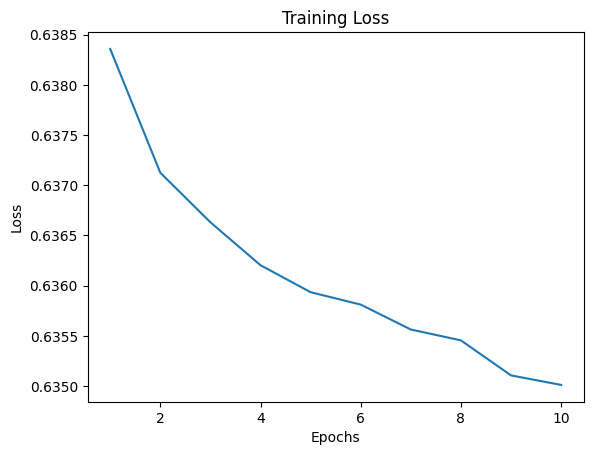

In [57]:
plt.plot(range(1,11),losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [58]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print(f"Accuracy:  {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall:    {recall_score(y_true, y_pred)}")
print(f"F1-score:  {f1_score(y_true, y_pred)}")

Accuracy:  0.6664575622608369
Precision: 0.6663526160417059
Recall:    0.9995289240625589
F1-score:  0.7996231392500471
